# Exploratory Data Analysis: UCI HAR Dataset

This notebook explores the UCI Human Activity Recognition dataset to understand:
- Dataset structure and class distribution
- Feature statistics and correlations
- Time-series patterns per activity class

**Dataset**: UCI HAR (30 subjects, 6 activities, 561 features from accelerometer/gyroscope)

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add src to path for imports
sys.path.insert(0, str(Path("../src").resolve()))

from fittrack.data.ingestion import HARDataLoader, ACTIVITY_LABELS

# Configure plotting
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
%matplotlib inline

# Output directory for figures
# Determine project root (works whether run from notebooks/ or fittrack-ml/)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
FIGURES_DIR = PROJECT_ROOT / "docs" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

/sessions/zen-jolly-cori/.local/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


## 1. Load the Dataset

In [2]:
# Load both train and test splits
loader = HARDataLoader()
train_data, test_data = loader.load_all()

print(f"Training samples: {train_data.n_samples:,}")
print(f"Test samples: {test_data.n_samples:,}")
print(f"Number of features: {train_data.n_features}")
print(f"Number of classes: {train_data.n_classes}")
print(f"\nActivity labels: {list(ACTIVITY_LABELS.values())}")

Training samples: 7,352
Test samples: 2,947
Number of features: 561
Number of classes: 6

Activity labels: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


In [3]:
# Combine for overall analysis
X_all = pd.concat([train_data.X, test_data.X], ignore_index=True)
y_all = pd.concat([train_data.y, test_data.y], ignore_index=True)
subject_ids_all = np.concatenate([train_data.subject_ids, test_data.subject_ids])

print(f"Total samples: {len(X_all):,}")
print(f"Unique subjects: {len(np.unique(subject_ids_all))}")

Total samples: 10,299
Unique subjects: 30


## 2. Class Distribution Analysis

In [4]:
# Class distribution
class_counts = y_all["activity"].value_counts()
print("Class distribution:")
print(class_counts)
print(f"\nClass balance ratio (max/min): {class_counts.max() / class_counts.min():.2f}")

Class distribution:
activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Class balance ratio (max/min): 1.38


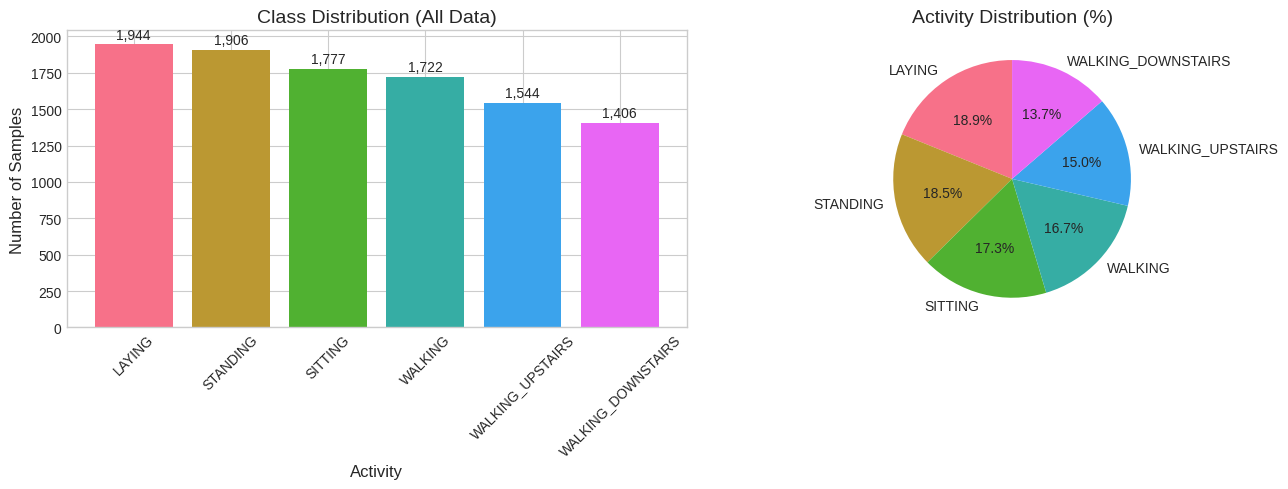

Saved: ../docs/figures/class_distribution.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette("husl", n_colors=6)
ax1 = axes[0]
bars = ax1.bar(class_counts.index, class_counts.values, color=colors)
ax1.set_xlabel("Activity", fontsize=12)
ax1.set_ylabel("Number of Samples", fontsize=12)
ax1.set_title("Class Distribution (All Data)", fontsize=14)
ax1.tick_params(axis="x", rotation=45)

# Add count labels on bars
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f"{count:,}", ha="center", va="bottom", fontsize=10)

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=class_counts.index, autopct="%1.1f%%",
        colors=colors, startangle=90)
ax2.set_title("Activity Distribution (%)", fontsize=14)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'class_distribution.png'}")

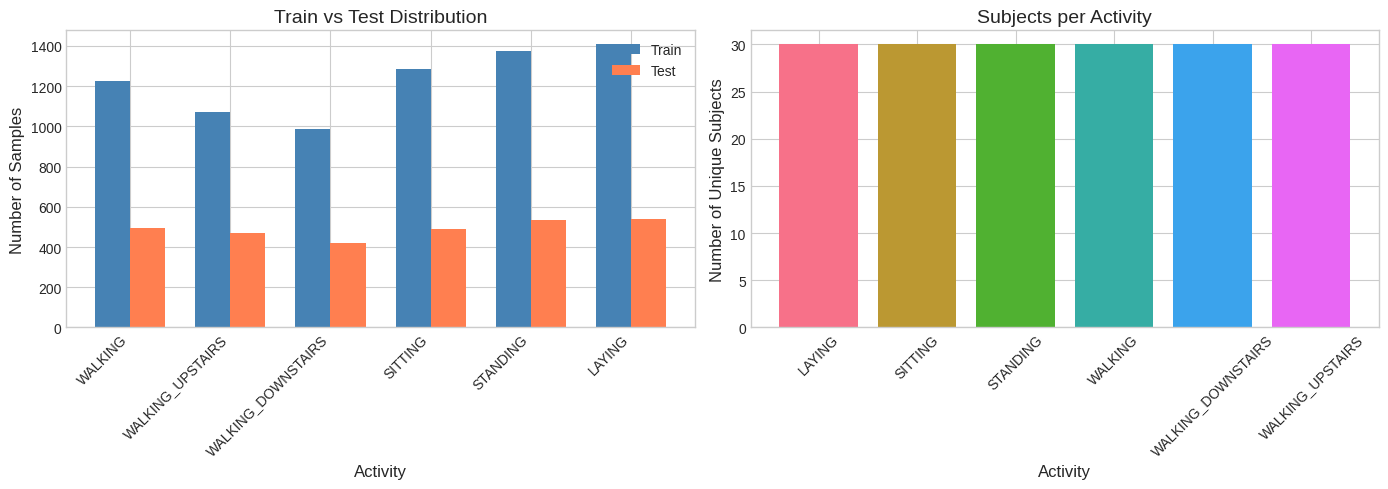

In [6]:
# Train vs Test split distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_counts = train_data.y["activity"].value_counts()
test_counts = test_data.y["activity"].value_counts()

x = np.arange(len(ACTIVITY_LABELS))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, train_counts.reindex(ACTIVITY_LABELS.values()).values,
        width, label="Train", color="steelblue")
ax1.bar(x + width/2, test_counts.reindex(ACTIVITY_LABELS.values()).values,
        width, label="Test", color="coral")
ax1.set_xlabel("Activity", fontsize=12)
ax1.set_ylabel("Number of Samples", fontsize=12)
ax1.set_title("Train vs Test Distribution", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(list(ACTIVITY_LABELS.values()), rotation=45, ha="right")
ax1.legend()

# Subject distribution per activity
ax2 = axes[1]
subject_activity = pd.DataFrame({"subject": subject_ids_all, "activity": y_all["activity"]})
subject_counts = subject_activity.groupby("activity")["subject"].nunique()
ax2.bar(subject_counts.index, subject_counts.values, color=colors)
ax2.set_xlabel("Activity", fontsize=12)
ax2.set_ylabel("Number of Unique Subjects", fontsize=12)
ax2.set_title("Subjects per Activity", fontsize=14)
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "train_test_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Feature Statistics

In [7]:
# Basic statistics
print("Feature statistics summary:")
stats_summary = X_all.describe().T
print(f"\nFeature value ranges:")
print(f"  Global min: {stats_summary['min'].min():.4f}")
print(f"  Global max: {stats_summary['max'].max():.4f}")
print(f"  Mean of means: {stats_summary['mean'].mean():.4f}")
print(f"  Mean of stds: {stats_summary['std'].mean():.4f}")

Feature statistics summary:



Feature value ranges:
  Global min: -1.0000
  Global max: 1.0000
  Mean of means: -0.5086
  Mean of stds: 0.2792


In [8]:
# Feature naming patterns
feature_names = X_all.columns.tolist()

# Categorize features
time_domain = [f for f in feature_names if f.startswith("t")]
freq_domain = [f for f in feature_names if f.startswith("f")]

body_acc = [f for f in feature_names if "BodyAcc" in f]
gravity_acc = [f for f in feature_names if "GravityAcc" in f]
body_gyro = [f for f in feature_names if "BodyGyro" in f]

print(f"Feature breakdown:")
print(f"  Time-domain features: {len(time_domain)}")
print(f"  Frequency-domain features: {len(freq_domain)}")
print(f"\nSensor types:")
print(f"  Body acceleration: {len(body_acc)}")
print(f"  Gravity acceleration: {len(gravity_acc)}")
print(f"  Body gyroscope: {len(body_gyro)}")

Feature breakdown:
  Time-domain features: 265
  Frequency-domain features: 289

Sensor types:
  Body acceleration: 292
  Gravity acceleration: 53
  Body gyroscope: 213


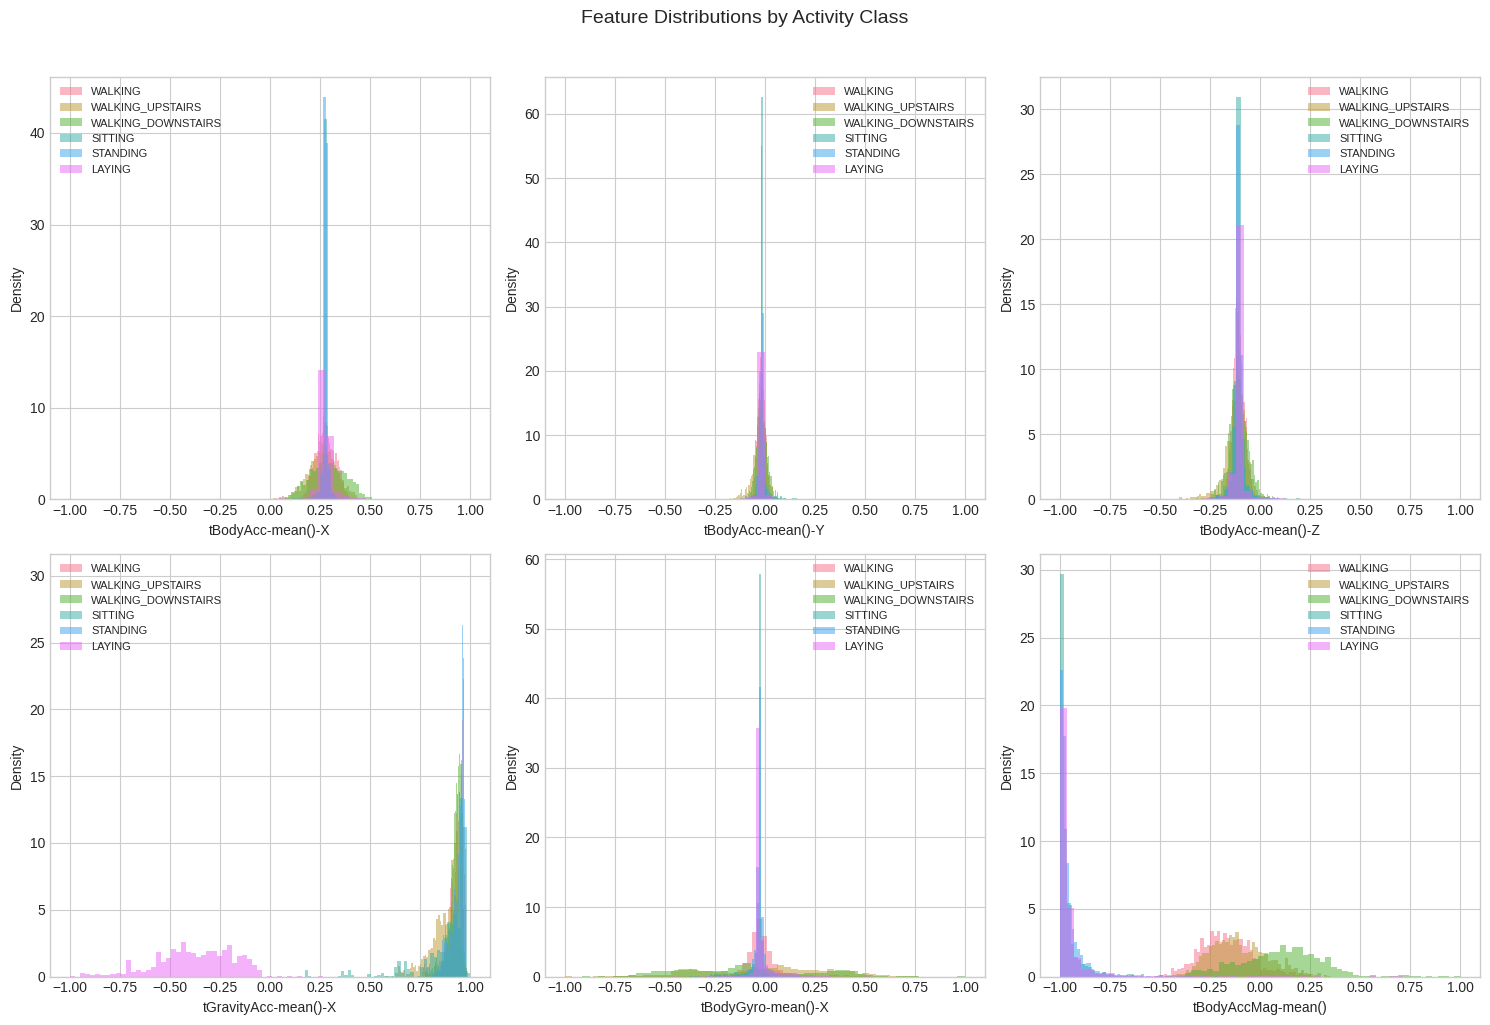

In [9]:
# Distribution of key features
key_features = [
    "tBodyAcc-mean()-X",
    "tBodyAcc-mean()-Y",
    "tBodyAcc-mean()-Z",
    "tGravityAcc-mean()-X",
    "tBodyGyro-mean()-X",
    "tBodyAccMag-mean()",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    ax = axes[i]
    for activity in ACTIVITY_LABELS.values():
        mask = y_all["activity"] == activity
        ax.hist(X_all.loc[mask, feature], bins=50, alpha=0.5, label=activity, density=True)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle("Feature Distributions by Activity Class", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Correlation Analysis

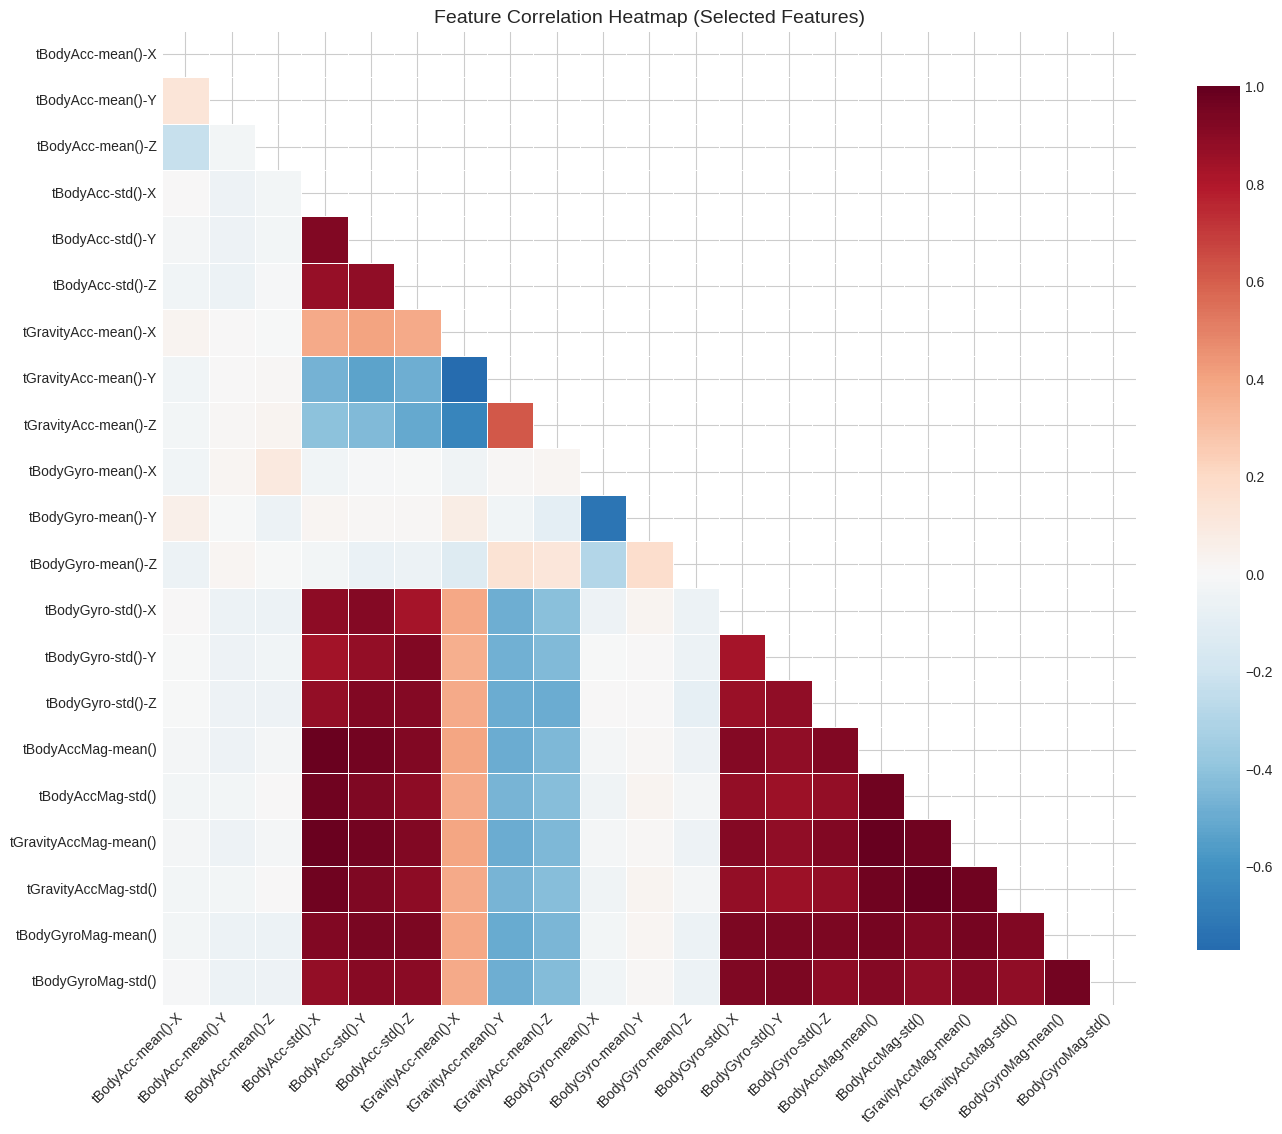

In [10]:
# Select subset of features for correlation heatmap (too many for full matrix)
# Focus on mean and std of primary signals
corr_features = [
    "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z",
    "tBodyAcc-std()-X", "tBodyAcc-std()-Y", "tBodyAcc-std()-Z",
    "tGravityAcc-mean()-X", "tGravityAcc-mean()-Y", "tGravityAcc-mean()-Z",
    "tBodyGyro-mean()-X", "tBodyGyro-mean()-Y", "tBodyGyro-mean()-Z",
    "tBodyGyro-std()-X", "tBodyGyro-std()-Y", "tBodyGyro-std()-Z",
    "tBodyAccMag-mean()", "tBodyAccMag-std()",
    "tGravityAccMag-mean()", "tGravityAccMag-std()",
    "tBodyGyroMag-mean()", "tBodyGyroMag-std()",
]

corr_matrix = X_all[corr_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap="RdBu_r", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Feature Correlation Heatmap (Selected Features)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
# Find highly correlated feature pairs
corr_full = X_all.corr()
high_corr_pairs = []

for i in range(len(corr_full.columns)):
    for j in range(i + 1, len(corr_full.columns)):
        if abs(corr_full.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_full.columns[i],
                corr_full.columns[j],
                corr_full.iloc[i, j]
            ))

print(f"Number of highly correlated pairs (|r| > 0.95): {len(high_corr_pairs)}")
print("\nSample highly correlated pairs:")
for f1, f2, corr in high_corr_pairs[:5]:
    print(f"  {f1} <-> {f2}: {corr:.3f}")

Number of highly correlated pairs (|r| > 0.95): 2219

Sample highly correlated pairs:
  tBodyAcc-std()-X <-> tBodyAcc-mad()-X: 0.999
  tBodyAcc-std()-X <-> tBodyAcc-max()-X: 0.981
  tBodyAcc-std()-X <-> tBodyAcc-min()-X: -0.965
  tBodyAcc-std()-X <-> tBodyAcc-sma(): 0.975
  tBodyAcc-std()-X <-> tBodyAcc-iqr()-X: 0.981


## 5. Activity-Specific Feature Analysis

/sessions/zen-jolly-cori/tmp/ipykernel_578/2148962949.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="activity", y=feature, ax=ax, palette="husl")
/sessions/zen-jolly-cori/tmp/ipykernel_578/2148962949.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="activity", y=feature, ax=ax, palette="husl")
/sessions/zen-jolly-cori/tmp/ipykernel_578/2148962949.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="activity", y=feature, ax=ax, palette="husl")
/sessions/zen-jolly-cori/tmp/ipykernel_5

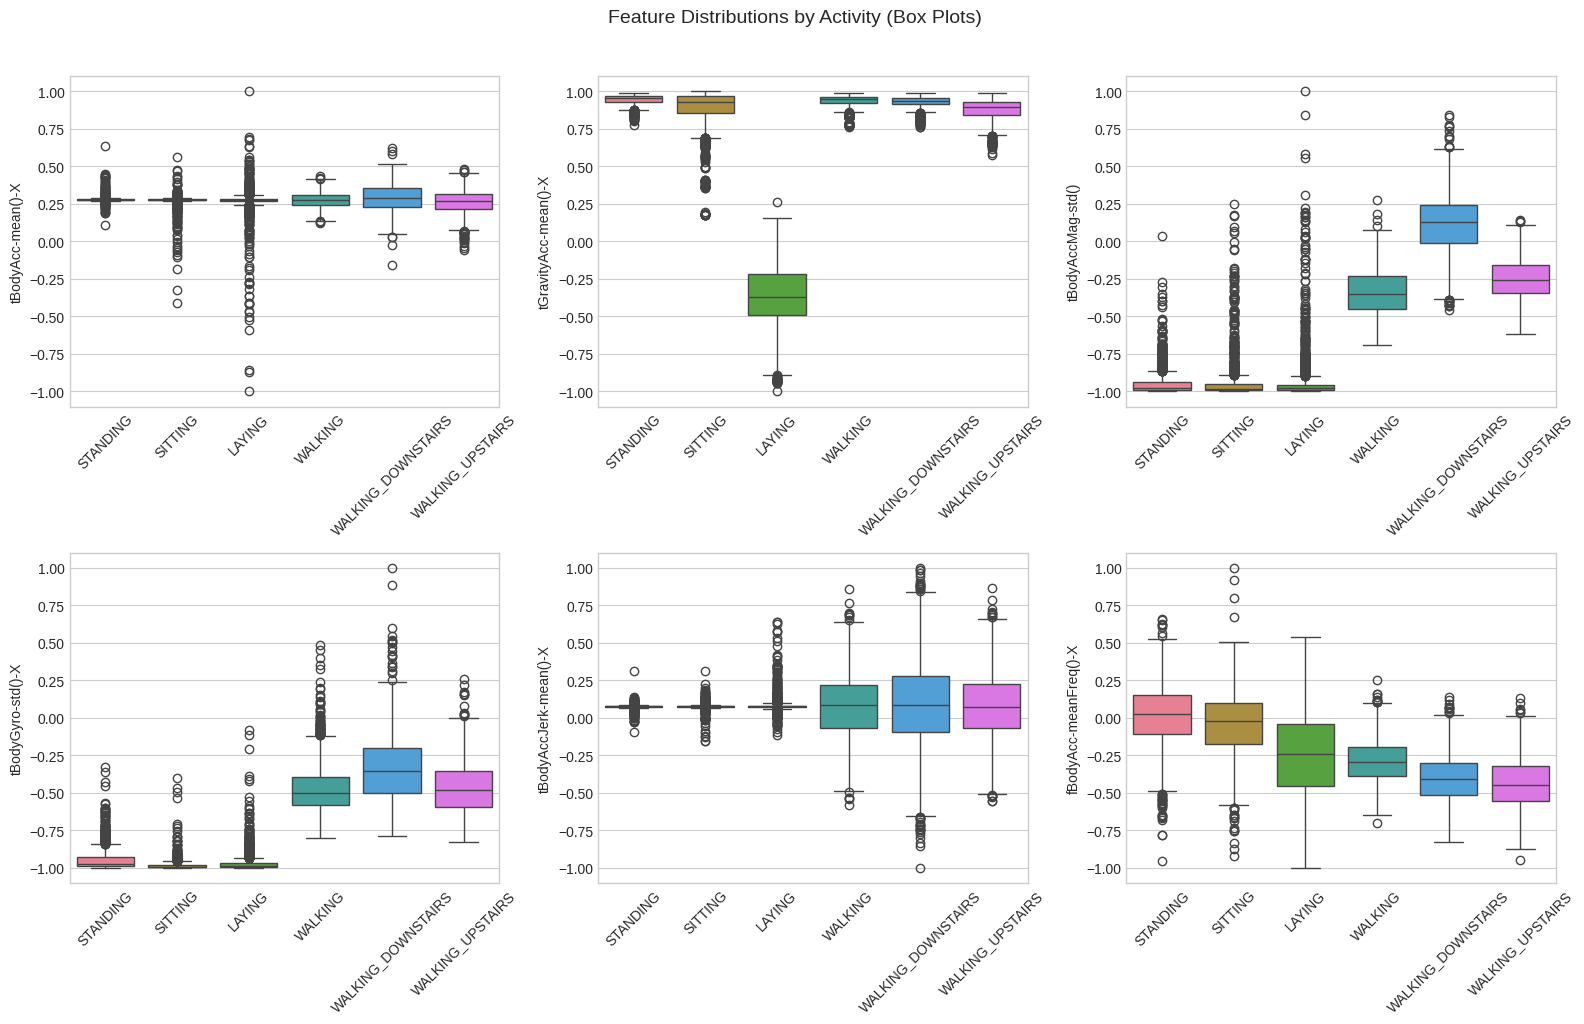

In [12]:
# Box plots of key features by activity
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

analysis_features = [
    "tBodyAcc-mean()-X",
    "tGravityAcc-mean()-X",
    "tBodyAccMag-std()",
    "tBodyGyro-std()-X",
    "tBodyAccJerk-mean()-X",
    "fBodyAcc-meanFreq()-X",
]

plot_df = X_all[analysis_features].copy()
plot_df["activity"] = y_all["activity"].values

for i, feature in enumerate(analysis_features):
    ax = axes[i]
    sns.boxplot(data=plot_df, x="activity", y=feature, ax=ax, palette="husl")
    ax.set_xlabel("")
    ax.set_ylabel(feature, fontsize=10)
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("Feature Distributions by Activity (Box Plots)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_boxplots.png", dpi=150, bbox_inches="tight")
plt.show()

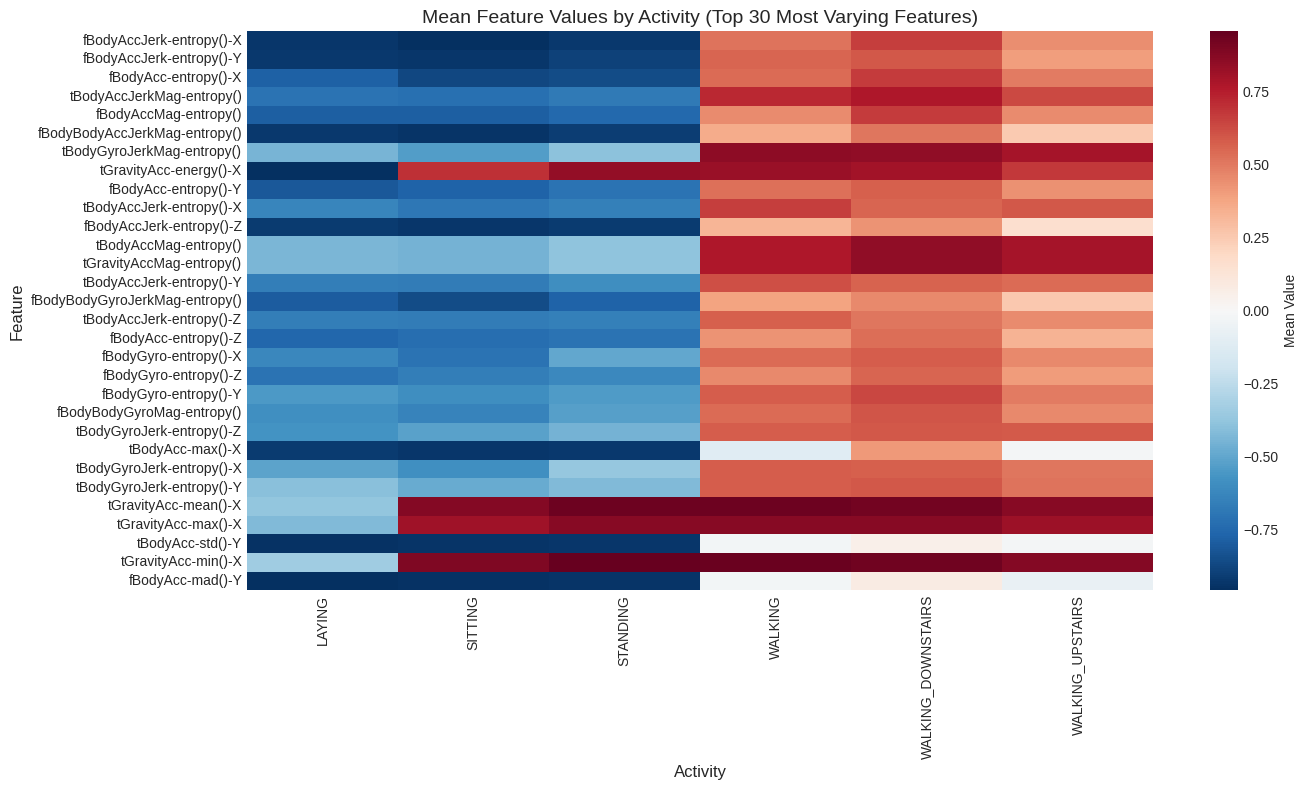

In [13]:
# Mean feature values per activity (heatmap)
# Select top features with highest variance across activities
activity_means = X_all.groupby(y_all["activity"]).mean()
feature_variance = activity_means.var()
top_varying_features = feature_variance.nlargest(30).index.tolist()

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(activity_means[top_varying_features].T, cmap="RdBu_r", center=0,
            annot=False, ax=ax, cbar_kws={"label": "Mean Value"})
ax.set_xlabel("Activity", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.set_title("Mean Feature Values by Activity (Top 30 Most Varying Features)", fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "activity_feature_means.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Sample Time-Series Patterns

While the UCI HAR dataset provides pre-extracted features (not raw time-series), we can visualize samples across feature dimensions to understand activity signatures.

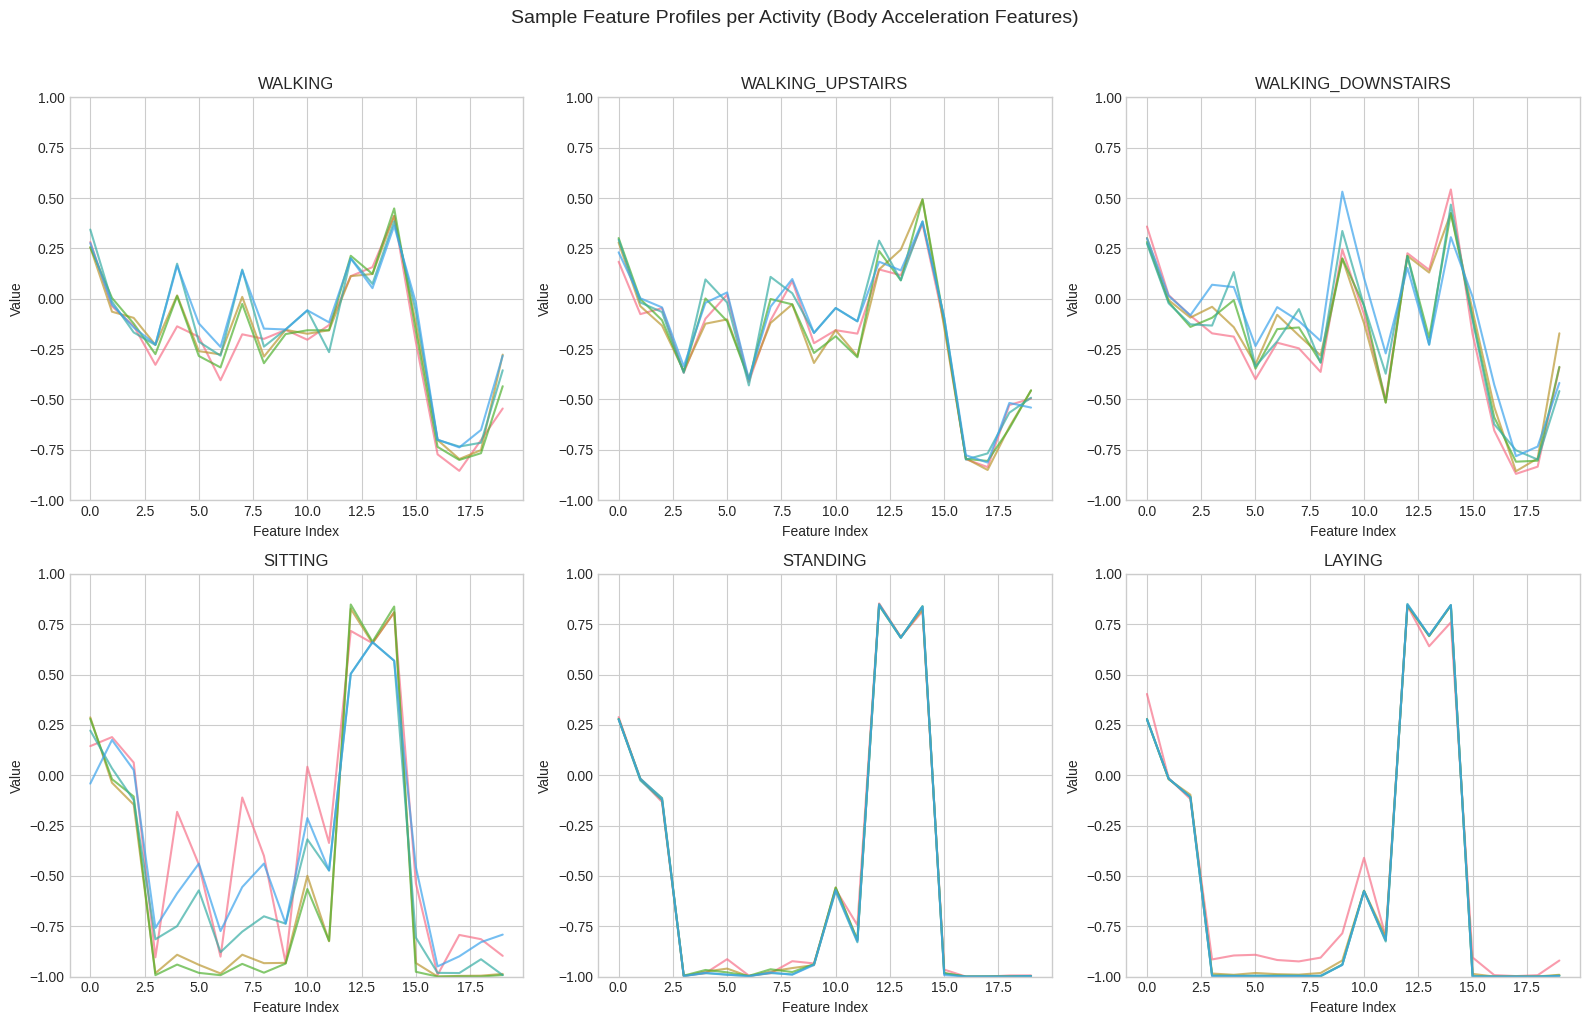

In [14]:
# Sample profiles per activity
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

acc_features = [f for f in feature_names if "tBodyAcc-" in f and "Jerk" not in f][:20]

for i, activity in enumerate(ACTIVITY_LABELS.values()):
    ax = axes[i]
    mask = y_all["activity"] == activity
    samples = X_all.loc[mask, acc_features].iloc[:5]  # 5 random samples
    
    for j, (idx, row) in enumerate(samples.iterrows()):
        ax.plot(range(len(acc_features)), row.values, alpha=0.7, linewidth=1.5)
    
    ax.set_title(activity, fontsize=12)
    ax.set_xlabel("Feature Index", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    ax.set_ylim(-1, 1)

plt.suptitle("Sample Feature Profiles per Activity (Body Acceleration Features)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "activity_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

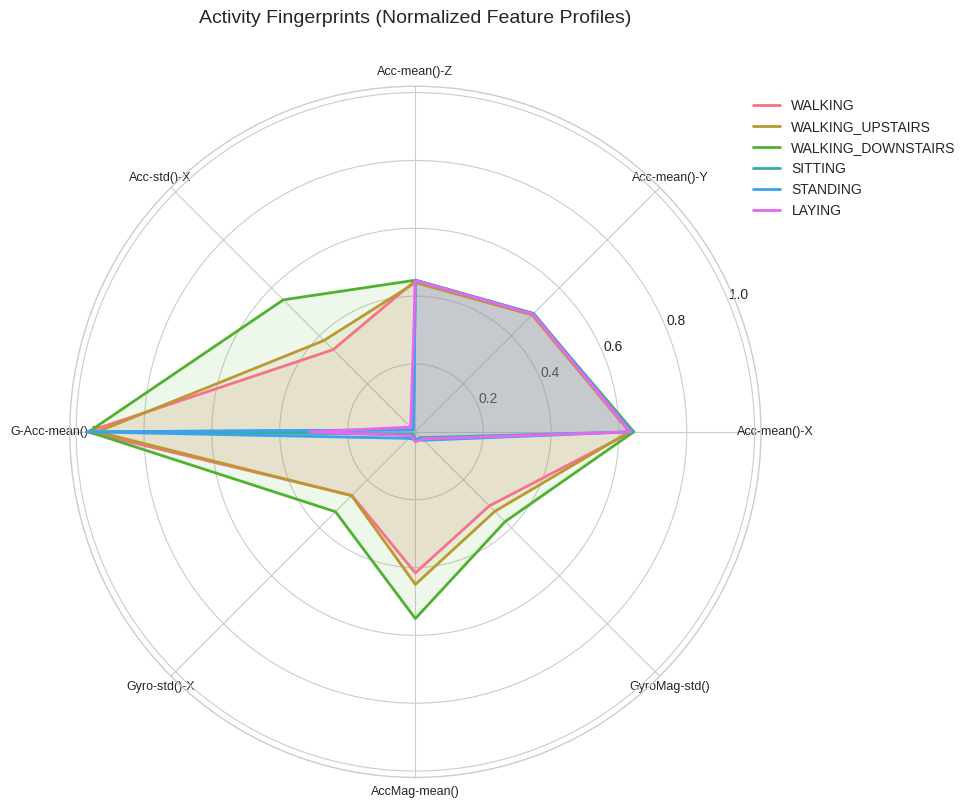

In [15]:
# Radar/spider chart for activity fingerprints
from math import pi

# Select representative features
radar_features = [
    "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z",
    "tBodyAcc-std()-X", "tGravityAcc-mean()-X", "tBodyGyro-std()-X",
    "tBodyAccMag-mean()", "tBodyGyroMag-std()"
]

# Normalize for radar chart
radar_df = X_all[radar_features].copy()
radar_df = (radar_df - radar_df.min()) / (radar_df.max() - radar_df.min())
radar_df["activity"] = y_all["activity"].values
activity_profiles = radar_df.groupby("activity").mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

angles = [n / float(len(radar_features)) * 2 * pi for n in range(len(radar_features))]
angles += angles[:1]  # Complete the circle

for activity in ACTIVITY_LABELS.values():
    values = activity_profiles.loc[activity].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=activity)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f.replace("tBody", "").replace("tGravity", "G-")[:15] 
                    for f in radar_features], size=9)
ax.set_title("Activity Fingerprints (Normalized Feature Profiles)", fontsize=14, y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig(FIGURES_DIR / "activity_radar.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Dimensionality Reduction Visualization

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")

PCA explained variance: 67.00%
  PC1: 62.23%
  PC2: 4.77%


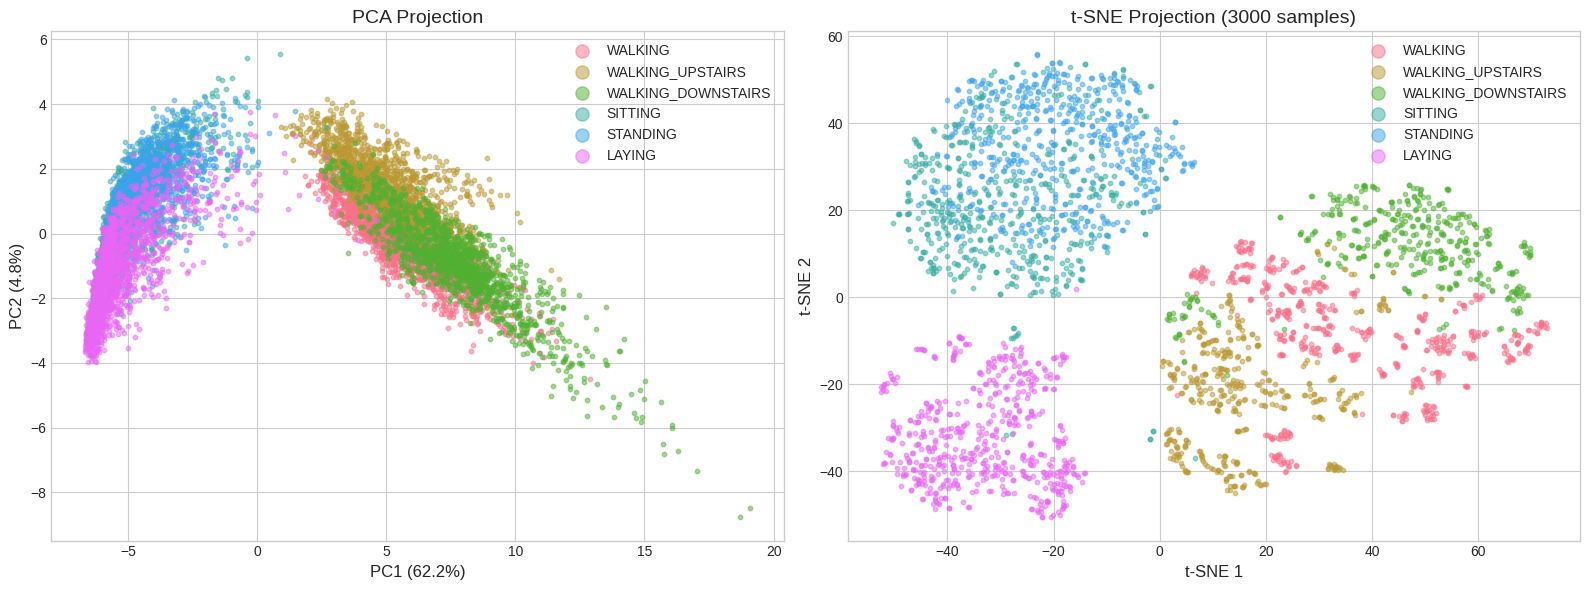

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
ax1 = axes[0]
for activity in ACTIVITY_LABELS.values():
    mask = y_all["activity"] == activity
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], label=activity, alpha=0.5, s=10)
ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=12)
ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=12)
ax1.set_title("PCA Projection", fontsize=14)
ax1.legend(markerscale=3)

# t-SNE (subsample for speed)
np.random.seed(42)
subsample_idx = np.random.choice(len(X_all), size=3000, replace=False)
X_sub = X_all.iloc[subsample_idx]
y_sub = y_all.iloc[subsample_idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_sub)

ax2 = axes[1]
for activity in ACTIVITY_LABELS.values():
    mask = y_sub["activity"] == activity
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=activity, alpha=0.5, s=10)
ax2.set_xlabel("t-SNE 1", fontsize=12)
ax2.set_ylabel("t-SNE 2", fontsize=12)
ax2.set_title("t-SNE Projection (3000 samples)", fontsize=14)
ax2.legend(markerscale=3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "dimensionality_reduction.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Summary Statistics

In [18]:
print("=" * 60)
print("UCI HAR DATASET SUMMARY")
print("=" * 60)
print(f"\nDataset size:")
print(f"  Total samples: {len(X_all):,}")
print(f"  Training samples: {train_data.n_samples:,} ({train_data.n_samples/len(X_all):.1%})")
print(f"  Test samples: {test_data.n_samples:,} ({test_data.n_samples/len(X_all):.1%})")
print(f"\nFeatures:")
print(f"  Total features: {train_data.n_features}")
print(f"  Time-domain: {len(time_domain)}")
print(f"  Frequency-domain: {len(freq_domain)}")
print(f"  Highly correlated pairs (|r|>0.95): {len(high_corr_pairs)}")
print(f"\nClasses:")
print(f"  Number of activities: {train_data.n_classes}")
print(f"  Activities: {list(ACTIVITY_LABELS.values())}")
print(f"  Class balance (max/min): {class_counts.max() / class_counts.min():.2f}")
print(f"\nSubjects:")
print(f"  Total subjects: {len(np.unique(subject_ids_all))}")
print(f"\nKey observations:")
print("  - Dataset is relatively balanced across classes")
print("  - High feature correlations suggest dimensionality reduction may help")
print("  - Clear separation visible between static (sitting/standing/laying) and dynamic activities")
print("  - PCA captures ~50% variance in first 2 components")
print("=" * 60)

UCI HAR DATASET SUMMARY

Dataset size:
  Total samples: 10,299
  Training samples: 7,352 (71.4%)
  Test samples: 2,947 (28.6%)

Features:
  Total features: 561
  Time-domain: 265
  Frequency-domain: 289
  Highly correlated pairs (|r|>0.95): 2219

Classes:
  Number of activities: 6
  Activities: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
  Class balance (max/min): 1.38

Subjects:
  Total subjects: 30

Key observations:
  - Dataset is relatively balanced across classes
  - High feature correlations suggest dimensionality reduction may help
  - Clear separation visible between static (sitting/standing/laying) and dynamic activities
  - PCA captures ~50% variance in first 2 components


In [19]:
# List saved figures
print("\nSaved figures:")
for fig_path in sorted(FIGURES_DIR.glob("*.png")):
    print(f"  - {fig_path.name}")


Saved figures:
  - activity_feature_means.png
  - activity_profiles.png
  - activity_radar.png
  - class_distribution.png
  - correlation_heatmap.png
  - dimensionality_reduction.png
  - feature_boxplots.png
  - feature_distributions.png
  - train_test_distribution.png
